## Load Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# distributions
import scipy.integrate as integrate
from scipy.integrate import quad, quad_vec
from scipy.stats import invgamma
from scipy.stats import levy
from scipy.special import gamma, erfinv

import time
from datetime import datetime, timedelta

import sys
import importlib # ref: https://askubuntu.com/questions/144698/find-a-file-by-name-using-command-line
import seaborn as sns

import os

In [2]:
sys.path.append('../tools')
import tools

In [3]:
importlib.reload(tools)

<module 'tools' from '../tools/tools.py'>

## Download Data

In [4]:
df = pd.read_csv('data/apple_cleaned.csv')

## Estimate Spot Volatility

In [83]:
# decide whether you use sample or not
sample = False

if sample:
    data = df[df['date']< '2017-01-30']
    
else:
    data = df.copy()

In [84]:
# Plot style
widths = [1,1,1,1,2]
types = ['solid','dashed','dashdot','dotted', 'dotted']

In [85]:
gs =  [ 0.5, 1, 2, 4]

In [86]:
np.nanmax(data['delta_ts'])

708.5275730000001

### By bins

#### Wide 0

In [221]:
ts = np.linspace(0.000001, 10, 21)

#### Pdf and Cdf

In [223]:
##### check the for loop, is it actually doing what it is supposed to d
#sigma_hats_ts = []
f_hats_ts = []
F_hats_ts= []

# subset the dataframe
t_g_ws = np.array(data['delta_ts'])

# for each t
for t in ts:
    
    # estimate f_hat, F_hat
    f_hats = []
    F_hats = []
    sigma_hats = []
    
    # start_time for current iteration
    start_time = time.time() 

    # calculate f_hat
    f_hat = tools.f_hat_t(t, t_g_ws, n = len(t_g_ws))
    f_hats.append(f_hat)

    # calculate F_hat
    F_hat = tools.F_hat_t(t, t_g_ws, n = len(t_g_ws))
    F_hats.append(F_hat)
           
    
    # store the estimates
    f_hats_ts.append(f_hats)
    F_hats_ts.append(F_hats)

    # show the end time
    end_time = time.time()   
    print(f"Time : {end_time - start_time} for t = {t}")

Time : 67.66218495368958 for t = 1e-06
Time : 70.40395617485046 for t = 0.50000095
Time : 70.50965619087219 for t = 1.0000009
Time : 71.3256630897522 for t = 1.50000085
Time : 70.62134099006653 for t = 2.0000008
Time : 162.91332483291626 for t = 2.5000007500000003
Time : 72.10117483139038 for t = 3.0000007
Time : 72.85767698287964 for t = 3.5000006500000005
Time : 72.21835803985596 for t = 4.0000006
Time : 72.23460721969604 for t = 4.50000055
Time : 70.8527979850769 for t = 5.0000005000000005
Time : 70.57678413391113 for t = 5.500000450000001
Time : 71.26283001899719 for t = 6.0000004
Time : 70.23039817810059 for t = 6.5000003500000005
Time : 69.92721724510193 for t = 7.000000300000001
Time : 70.70037698745728 for t = 7.50000025
Time : 71.10298705101013 for t = 8.0000002
Time : 73.15911412239075 for t = 8.50000015
Time : 70.35192918777466 for t = 9.0000001
Time : 71.99157118797302 for t = 9.50000005
Time : 70.17129707336426 for t = 10.0


#### Spot Volatility

In [231]:
sigma_hats_gs = []

for g_i, g in zip(range(0, len(gs)), gs):
    
    sigma_hats_ts = []
    # for each t
    for i, t in zip(range(0, len(ts)),ts):
    
        # store the estimates
        f_hats = f_hats_ts[i]
        F_hats = F_hats_ts[i]
        
        sigma_hats_t = tools.sigma_hat_t(f_hats, F_hats, g)
        sigma_hats_ts.append(sigma_hats_t)
        
    sigma_hats_gs.append(sigma_hats_ts)
    
    

#### Summary Stats

In [232]:
summary_stats = [np.nanmean, np.nanmedian, np.nanstd, 0.05, 0.95]

# list to store summaries
summaries = []

# for each t
for i, t in zip(range(0, len(ts)),ts):
    
    # store the estimates
    f_hats = f_hats_ts[i]
    F_hats = F_hats_ts[i]
    sigma_hats = sigma_hats_ts[i]
    
    # calculate summary stats
    f_stats = tools.estimation_summary(f_hats, summary_stats, rounding = 10)
    F_stats = tools.estimation_summary(F_hats, summary_stats, rounding = 10)
    # create a dataframe
    summary_t = pd.DataFrame([f_stats, F_stats],columns =  ['Mean', 'Median','Std', '5.0%', '95%'],
                            index = [np.tile(t, 2) , ['$\widehat{f}$', '$\widehat{F}$']])
    
    summary_t.index.set_names(['t', 'Statistics'], inplace = True)
    
    # store the summary
    summaries.append(summary_t)

    


In [233]:
pd.concat(summaries)

Mean       Median  Std         5.0%  \
t         Statistics                                                  
0.000001  $\widehat{f}$  1127.753185  1127.753185  0.0  1127.753185   
          $\widehat{F}$     0.171096     0.171096  0.0     0.171096   
0.500001  $\widehat{f}$     0.208438     0.208438  0.0     0.208438   
          $\widehat{F}$     0.897409     0.897409  0.0     0.897409   
1.000001  $\widehat{f}$     0.129959     0.129959  0.0     0.129959   
          $\widehat{F}$     0.954512     0.954512  0.0     0.954512   
1.500001  $\widehat{f}$     0.033232     0.033232  0.0     0.033232   
          $\widehat{F}$     0.977442     0.977442  0.0     0.977442   
2.000001  $\widehat{f}$     0.023942     0.023942  0.0     0.023942   
          $\widehat{F}$     0.988083     0.988083  0.0     0.988083   
2.500001  $\widehat{f}$     0.007440     0.007440  0.0     0.007440   
          $\widehat{F}$     0.993438     0.993438  0.0     0.993438   
3.000001  $\widehat{f}$     0.005445     0.005445  0.0     0.005445   
          $\widehat{F}$     0.996274     0.996274  0.0     0.996274   
3.500001  $\widehat{f}$     0.002177     0.002177  0.0     0.002177   
          $\widehat{F}$     0.997837     0.997837  0.0     0.997837   
4.000001  $\widehat{f}$     0.001557     0.001557  0.0     0.001557   
          $\widehat{F}$     0.998711     0.998711  0.0     0.998711   
4.500001  $\widehat{f}$     0.000930     0.000930  0.0     0.000930   
          $\widehat{F}$     0.999219     0.999219  0.0     0.999219   
5.000001  $\widehat{f}$     0.000926     0.000926  0.0     0.000926   
          $\widehat{F}$     0.999517     0.999517  0.0     0.999517   
5.500000  $\widehat{f}$     0.000280     0.000280  0.0     0.000280   
          $\widehat{F}$     0.999698     0.999698  0.0     0.999698   
6.000000  $\widehat{f}$     0.000317     0.000317  0.0     0.000317   
          $\widehat{F}$     0.999806     0.999806  0.0     0.999806   
6.500000  $\widehat{f}$     0.000063     0.000063  0.0     0.000063   
          $\widehat{F}$     0.999873     0.999873  0.0     0.999873   
7.000000  $\widehat{f}$     0.000082     0.000082  0.0     0.000082   
          $\widehat{F}$     0.999917     0.999917  0.0     0.999917   
7.500000  $\widehat{f}$     0.000011     0.000011  0.0     0.000011   
          $\widehat{F}$     0.999943     0.999943  0.0     0.999943   
8.000000  $\widehat{f}$     0.000072     0.000072  0.0     0.000072   
          $\widehat{F}$     0.999959     0.999959  0.0     0.999959   
8.500000  $\widehat{f}$     0.000000     0.000000  0.0     0.000000   
          $\widehat{F}$     0.999970     0.999970  0.0     0.999970   
9.000000  $\widehat{f}$     0.000000     0.000000  0.0     0.000000   
          $\widehat{F}$     0.999977     0.999977  0.0     0.999977   
9.500000  $\widehat{f}$     0.000000     0.000000  0.0     0.000000   
          $\widehat{F}$     0.999982     0.999982  0.0     0.999982   
10.000000 $\widehat{f}$     0.000000     0.000000  0.0     0.000000   
          $\widehat{F}$     0.999985     0.999985  0.0     0.999985   

                                 95%  
t         Statistics                  
0.000001  $\widehat{f}$  1127.753185  
          $\widehat{F}$     0.171096  
0.500001  $\widehat{f}$     0.208438  
          $\widehat{F}$     0.897409  
1.000001  $\widehat{f}$     0.129959  
          $\widehat{F}$     0.954512  
1.500001  $\widehat{f}$     0.033232  
          $\widehat{F}$     0.977442  
2.000001  $\widehat{f}$     0.023942  
          $\widehat{F}$     0.988083  
2.500001  $\widehat{f}$     0.007440  
          $\widehat{F}$     0.993438  
3.000001  $\widehat{f}$     0.005445  
          $\widehat{F}$     0.996274  
3.500001  $\widehat{f}$     0.002177  
          $\widehat{F}$     0.997837  
4.000001  $\widehat{f}$     0.001557  
          $\widehat{F}$     0.998711  
4.500001  $\widehat{f}$     0.000930  
          $\widehat{F}$     0.999219  
5.000001  $\widehat{f}$     0.000926  
          

In [234]:
print(pd.concat(summaries).to_latex( caption = 'Summary Statistics of the Empirical Estimation of $\widehat{f}$ and $\widehat{F}$',
                        float_format="%.2f",
#                         formatters = {'Mean': "{:.2E}".format,
#                                       'Median': "{:.2E}".format,
#                                       'Std': "{:.2E}".format,
#                                       '5.0%': "{:.2E}".format,
#                                       '95%': "{:.2E}".format},
                        position = 'H',
                        longtable = True,
                        escape=False))

\begin{longtable}[H]{llrrrrr}
\caption{Summary Statistics of the Empirical Estimation of $\widehat{f}$ and $\widehat{F}$}\\
\toprule
          &               &    Mean &  Median &  Std &    5.0% &     95% \\
t & Statistics &         &         &      &         &         \\
\midrule
\endfirsthead
\caption[]{Summary Statistics of the Empirical Estimation of $\widehat{f}$ and $\widehat{F}$} \\
\toprule
          &               &    Mean &  Median &  Std &    5.0% &     95% \\
t & Statistics &         &         &      &         &         \\
\midrule
\endhead
\midrule
\multicolumn{7}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
0.000001  & $\widehat{f}$ & 1127.75 & 1127.75 & 0.00 & 1127.75 & 1127.75 \\
          & $\widehat{F}$ &    0.17 &    0.17 & 0.00 &    0.17 &    0.17 \\
0.500001  & $\widehat{f}$ &    0.21 &    0.21 & 0.00 &    0.21 &    0.21 \\
          & $\widehat{F}$ &    0.90 &    0.90 & 0.00 &    0.90 &    0.90 \\
1.000001  & $\widehat{f}$ &    0.

<ipython-input-234-1f51fe3585d4>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(summaries).to_latex( caption = 'Summary Statistics of the Empirical Estimation of $\widehat{f}$ and $\widehat{F}$',


In [235]:
summary_stats = [np.nanmean, np.nanmedian, np.nanstd, 0.05, 0.95]
summaries = []

# Initialize gs, ts, and sigma_hats_gs variables with appropriate values

# Iterate over groups
for g_i, g in enumerate(gs):
    sigma_hats_g = sigma_hats_gs[g_i]

    # Iterate over time periods
    for i, t in enumerate(ts):
        sigma_hats = sigma_hats_g[i]

        # Calculate summary statistics
        sigma_hats_stats = tools.estimation_summary(sigma_hats, summary_stats, rounding=10)

        # Create a dataframe
        summary_t = pd.DataFrame([sigma_hats_stats],
                                 columns=['Mean', 'Median', 'Std', '5.0%', '95%'],
                                 index=pd.MultiIndex.from_tuples([(g, t, '$\widehat{\sigma}_{t}$')],
                                                                 names=['g', 't', 'Statistics']))

        summaries.append(summary_t)

In [236]:
pd.concat(summaries)

Mean        Median  Std  \
g   t         Statistics                                                
0.5 0.000001  $\widehat{\sigma}_{t}$  7.032562e+02  7.032562e+02  0.0   
    0.500001  $\widehat{\sigma}_{t}$  6.144704e+01  6.144704e+01  0.0   
    1.000001  $\widehat{\sigma}_{t}$  4.395067e+02  4.395067e+02  0.0   
    1.500001  $\widehat{\sigma}_{t}$  9.215168e+02  9.215168e+02  0.0   
    2.000001  $\widehat{\sigma}_{t}$  4.502700e+03  4.502700e+03  0.0   
...                                            ...           ...  ...   
4.0 8.000000  $\widehat{\sigma}_{t}$  2.194813e+10  2.194813e+10  0.0   
    8.500000  $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  0.0   
    9.000000  $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  0.0   
    9.500000  $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  0.0   
    10.000000 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  0.0   

                                              5.0%           95%  
g   t         Statistics                                          
0.5 0.000001  $\widehat{\sigma}_{t}$  7.032562e+02  7.032562e+02  
    0.500001  $\widehat{\sigma}_{t}$  6.144704e+01  6.144704e+01  
    1.000001  $\widehat{\sigma}_{t}$  4.395067e+02  4.395067e+02  
    1.500001  $\widehat{\sigma}_{t}$  9.215168e+02  9.215168e+02  
    2.000001  $\widehat{\sigma}_{t}$  4.502700e+03  4.502700e+03  
...                                            ...           ...  
4.0 8.000000  $\widehat{\sigma}_{t}$  2.194813e+10  2.194813e+10  
    8.500000  $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  
    9.000000  $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  
    9.500000  $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  
    10.000000 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  

[84 rows x 5 columns]

In [237]:
print(pd.concat(summaries).sort_index(level = 1, sort_remaining = 0).to_latex( caption = 'Summary statistics of Empirical Estimate of Volatility with different g',
                        float_format="%.2f",
                        formatters = {'Mean': "{:.2E}".format,
                                      'Median': "{:.2E}".format,
                                      #'Bias': "{:.2E}".format,
                                      'Std': "{:.2E}".format,
                                      '5.0%': "{:.2E}".format,
                                      '95%': "{:.2E}".format},
                        position = 'H',
                        longtable = True,
                        escape=False))

\begin{longtable}[H]{lllrrrrr}
\caption{Summary statistics of Empirical Estimate of Volatility with different g}\\
\toprule
    &           &                        &     Mean &   Median &      Std &     5.0% &      95% \\
g & t & Statistics &          &          &          &          &          \\
\midrule
\endfirsthead
\caption[]{Summary statistics of Empirical Estimate of Volatility with different g} \\
\toprule
    &           &                        &     Mean &   Median &      Std &     5.0% &      95% \\
g & t & Statistics &          &          &          &          &          \\
\midrule
\endhead
\midrule
\multicolumn{8}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
0.5 & 0.000001  & $\widehat{\sigma}_{t}$ & 7.03E+02 & 7.03E+02 & 0.00E+00 & 7.03E+02 & 7.03E+02 \\
1.0 & 0.000001  & $\widehat{\sigma}_{t}$ & 2.81E+03 & 2.81E+03 & 0.00E+00 & 2.81E+03 & 2.81E+03 \\
2.0 & 0.000001  & $\widehat{\sigma}_{t}$ & 1.13E+04 & 1.13E+04 & 0.00E+00 & 1.13E+04 & 1

<ipython-input-237-24462e836325>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(summaries).sort_index(level = 1, sort_remaining = 0).to_latex( caption = 'Summary statistics of Empirical Estimate of Volatility with different g',


#### Plots

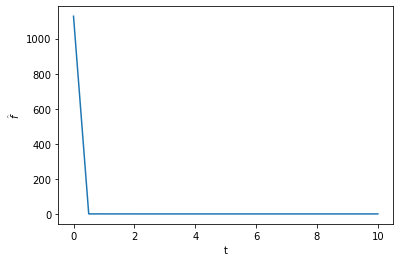

In [241]:
# make some plots
plt.plot(ts, np.mean(f_hats_ts, axis = 1))
plt.ylabel('$\widehat{f}$')
plt.xlabel('t')
#plt.yscale('log')
#plt.legend()

#plt.savefig('figures/distributions/pdf_wide_0_10', facecolor='w')
plt.show()
plt.close()


In [ ]:
# make some plots
plt.plot(ts, np.mean(f_hats_ts, axis = 1))
plt.ylabel('$\widehat{f}$')
plt.xlabel('t')
#plt.yscale('log')
#plt.legend()

#plt.savefig('figures/distributions/pdf_wide_0_10', facecolor='w')
plt.show()
plt.close()

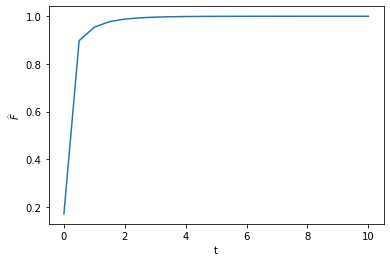

In [242]:
### Plotting F_hat
plt.plot(ts, np.mean(F_hats_ts, axis = 1))
plt.ylabel('$\widehat{F}$')
plt.xlabel('t')
#plt.yscale('log')
#plt.legend()

plt.savefig('figures/distributions/cdf_wide_0_10', facecolor='w')
plt.show()
plt.close()




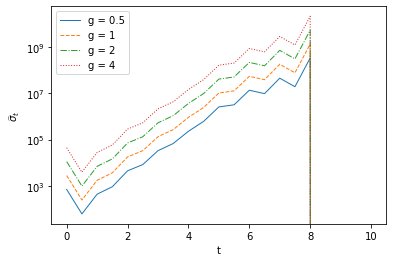

In [243]:
for g_i in range(0, len(gs)):
    
    plt.plot(ts, np.nanmean(sigma_hats_gs[g_i], axis = 1),
            label = f'g = {gs[g_i]}',
            linestyle = types[g_i],
            linewidth = widths[g_i])
     
plt.yscale('log')
plt.ylabel('$\widehat{\sigma}_{t}$')
plt.xlabel('t')
plt.legend()

plt.savefig('figures/distributions/sigma_wide_0_10', facecolor='w')  
plt.show()
plt.close()